# 공부 좀 하겠음.. ㅎㅎ

In [10]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
from datetime import datetime, timedelta
import random as r

def generate_time_series(start_date, num_samples, freq='H'):
    timestamps = pd.date_range(start=start_date, periods=num_samples, freq=freq)
    data1 = np.sin(np.arange(num_samples) * 0.02)  # 예시 데이터 (sin 곡선)
    data2 = np.sin(np.arange(num_samples) * 0.04)  # 예시 데이터 (sin 곡선)
    data3 = np.sin(np.arange(num_samples) * 0.06)  # 예시 데이터 (sin 곡선)
    return pd.DataFrame({'timestamp': timestamps, 'data1': data1, 'data2': data2, 'data3': data3})

# datetime 형식의 타임스탬프를 가진 시계열 데이터 생성
start_date = datetime(2023, 1, 1)
num_samples = 730
freq = 'D'
df = generate_time_series(start_date, num_samples, freq)

# 예시 데이터 생성
data = df
targets = np.array([[np.random.random()] for _ in range(num_samples)])

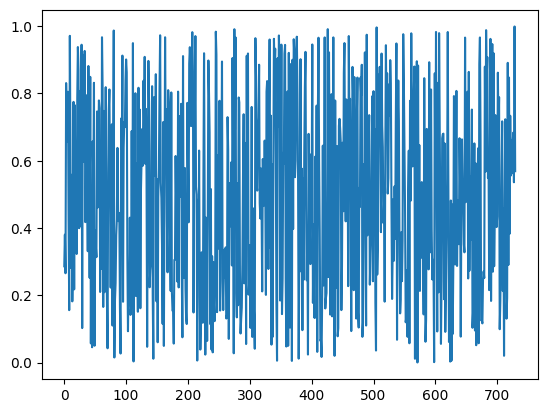

In [2]:
import matplotlib.pyplot as plt

plt.plot(targets)

In [3]:
targets.shape

(730, 1)

In [4]:
# sequence_length: 각 시퀀스의 길이
# targets: 예측하려는 시퀀스의 다음 값을 나타내는 데이터
# length: 각 시퀀스의 길이
# batch_size: 생성된 시퀀스 배치의 수 

In [5]:
# TimeSeriesGenerator 생성
sequence_length = 30  # 시퀀스 길이 (1개월)
batch_size = 16

# 데이터의 시간 순서를 유지하기 위해 정렬
data.sort_values('timestamp', inplace=True)
data.reset_index(drop=True, inplace=True)

train_data = data[['data1', 'data2', 'data3']].values

train_gen = TimeseriesGenerator(train_data, targets, length=sequence_length, batch_size=batch_size)

# 생성된 배치의 크기 출력
print(f"Number of batches: {len(train_gen)}")

Number of batches: 44


In [6]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Embedding

class TransformerBlock(Model):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TimeSeriesTransformer(Model):
    def __init__(self, num_heads, embed_dim, ff_dim, num_layers):
        super(TimeSeriesTransformer, self).__init__()
        self.embed = Dense(embed_dim)
        self.transformer_blocks = [
            TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)
        ]
        self.final_layer = Dense(1)  # 3개의 출력, 각 특성에 대해 하나씩

    def call(self, inputs):
        x = self.embed(inputs)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        return self.final_layer(x)

# 모델 초기화
embed_dim = 64  # 임베딩 차원
num_heads = 4  # 어텐션 헤드 수
ff_dim = 64  # 피드 포워드 네트워크 차원
num_layers = 3  # Transformer 블록 수

model = TimeSeriesTransformer(num_heads, embed_dim, ff_dim, num_layers)
model.compile(optimizer='adam', loss=MeanSquaredError())
model.build(input_shape=(None, sequence_length, 3))
model.summary()

# 모델 학습
history = model.fit(train_gen, epochs=100, verbose=1)


2024-05-28 16:51:27.865115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "time_series_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  256       
                                                                 
 transformer_block (Transfor  multiple                 74944     
 merBlock)                                                       
                                                                 
 transformer_block_1 (Transf  multiple                 74944     
 ormerBlock)                                                     
                                                                 
 transformer_block_2 (Transf  multiple                 74944     
 ormerBlock)                                                     
                                                                 
 dense_7 (Dense)             multiple                  65        
                                           

1/1 [==============================] - 0s 422ms/step
(1, 30, 1)
1/1 [==============================] - 0s 14ms/step
(1, 30, 1)
1/1 [==============================] - 0s 15ms/step
(1, 30, 1)
1/1 [==============================] - 0s 15ms/step
(1, 30, 1)
1/1 [==============================] - 0s 15ms/step
(1, 30, 1)
1/1 [==============================] - 0s 17ms/step
(1, 30, 1)
1/1 [==============================] - 0s 16ms/step
(1, 30, 1)
1/1 [==============================] - 0s 16ms/step
(1, 30, 1)
1/1 [==============================] - 0s 15ms/step
(1, 30, 1)
1/1 [==============================] - 0s 15ms/step
(1, 30, 1)
1/1 [==============================] - 0s 14ms/step
(1, 30, 1)
1/1 [==============================] - 0s 15ms/step
(1, 30, 1)
1/1 [==============================] - 0s 15ms/step
(1, 30, 1)
1/1 [==============================] - 0s 14ms/step
(1, 30, 1)
1/1 [==============================] - 0s 14ms/step
(1, 30, 1)
1/1 [==============================] - 0s 34ms/step
(1

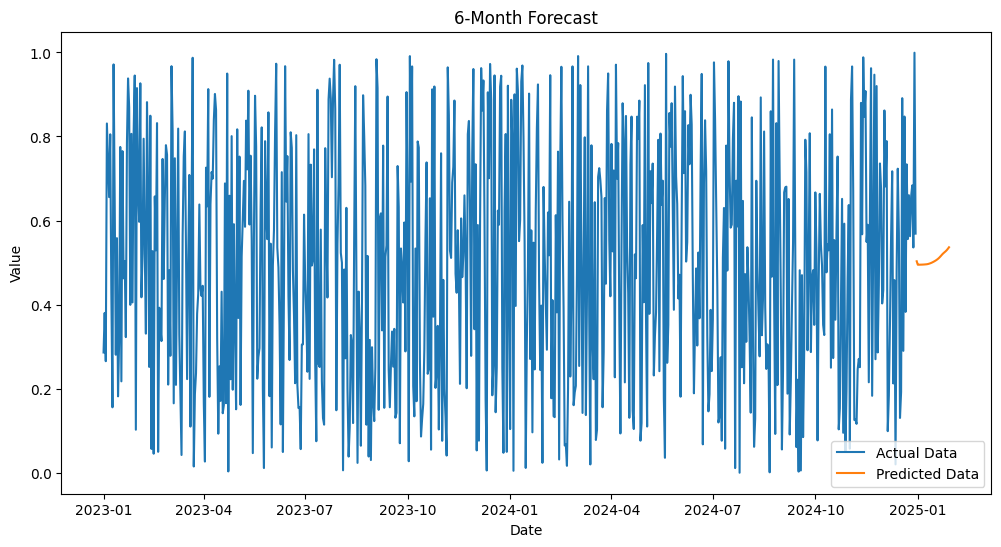

In [7]:
# 미래 6개월 예측 (6개월 = 약 180일)
# future_steps = 180
future_steps = 30 # 180일은 좀 오바인 것 같아서 30일을 예측해봄.
 
# 마지막 입력 시퀀스 가져오기
last_sequence = train_data[-sequence_length:] # sequence length - 30

# 미래 예측 수행
predictions = []
current_sequence = last_sequence

for _ in range(future_steps): 
    current_sequence = current_sequence.reshape((1, sequence_length, 3)) # 1, seq_length, number of columns 
    #reshaped to (1, 30, 3)
    next_value = model.predict(current_sequence) # 모델이 예측을 한다. 
    predictions.append(next_value[0, 0])
    print(next_value.shape)
    next_value_scaled = np.array([next_value[0, 0]] * 3).reshape(1, 1, 3) # next_value를 3개의 동일한 값으로 확장
    current_sequence = np.append(current_sequence[:, 1:, :], next_value_scaled.reshape(1, 1, 3), axis=1) #.reshape(sequence_length, 3)

# 예측 결과 역정규화
# predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# 예측 결과 시각화
import matplotlib.pyplot as plt

future_dates = pd.date_range(df['timestamp'].iloc[-1] + timedelta(days=1), periods=future_steps, freq='D')

plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], targets, label='Actual Data')
plt.plot(future_dates, predictions, label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('6-Month Forecast')
plt.legend()
plt.show()

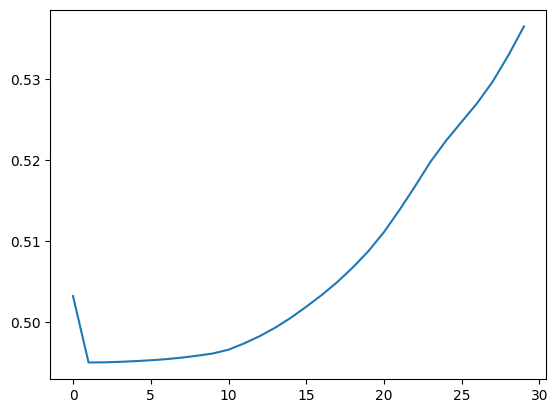

In [8]:
plt.plot(predictions)

# 새로운 모델을 진짜 AutoML (Auto-sklearn, Auto-keras를 통해 제작)

*우선 전처리*

In [9]:
df = pd.read_csv('../data/전처리 완료/dataset.csv')
df

,Unnamed: 0,hour,SO2,CO,O3,NO2,PM10,PM25,지역,지역명,...,시작점,종점,기온,습도,재비산먼지 평균농도,오염범례,minute,기준치초과 유무,평균속도,최고속도
0,0,14,0.002,0.4,0.049,0.009,16.0,8.0,서울,강서구,...,서울특별시 강서구 화곡동 662-19도,서울특별시 강서구 화곡동 662-10도,15.0,57.0,209.0,1.0,22.0,1,20.366205,31.818182
1,1,14,0.003,0.4,0.030,0.032,28.0,9.0,서울,강서구,...,서울특별시 강서구 화곡동 662-19도,서울특별시 강서구 화곡동 662-10도,15.0,57.0,209.0,1.0,22.0,1,20.366205,31.818182
2,2,10,0.005,0.5,0.036,0.031,70.0,50.0,서울,양천구,...,서울특별시 양천구 신월동,서울특별시 양천구 신월동 39-5 도,13.0,43.0,23.0,5.0,22.0,0,20.366205,31.818182
3,3,13,0.003,0.3,0.044,0.014,183.0,14.0,서울,강서구,...,서울특별시 강서구 화곡동 662-19도,서울특별시 강서구 화곡동 662-10도,23.0,20.0,39.0,5.0,38.0,0,20.366205,31.818182
4,4,13,0.003,0.3,0.030,0.035,166.0,19.0,서울,강서구,...,서울특별시 강서구 화곡동 662-19도,서울특별시 강서구 화곡동 662-10도,23.0,20.0,39.0,5.0,38.0,0,20.366205,31.818182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6710,8680,11,0.004,0.9,0.011,0.062,39.0,25.0,서울,동작구,...,서울특별시 동작구 흑석동 336-7 도,서울특별시 동작구 흑석동 25-2도,6.0,56.0,7.0,5.0,10.0,0,25.594534,49.577903
6711,8681,12,0.006,0.8,0.021,0.056,84.0,44.0,서울,동작구,...,서울특별시 동작구 흑석동 336-7 도,서울특별시 동작구 흑석동 25-2도,14.0,58.0,47.0,5.0,23.0,0,25.594534,49.577903
6712,8682,12,0.005,0.9,0.017,0.063,83.0,44.0,서울,동작구,...,서울특별시 동작구 흑석동 336-7 도,서울특별시 동작구 흑석동 25-2도,14.0,58.0,47.0,5.0,23.0,0,25.594534,49.577903
6713,8683,10,0.003,0.4,0.042,0.020,36.0,25.0,서울,동작구,...,서울특별시 동작구 흑석동 336-7 도,서울특별시 동작구 흑석동 25-2도,7.0,56.0,96.0,4.0,57.0,0,25.594534,49.577903


시작점, 종점 위경도 변환홰주고 지역은 encoding 진행해주고 AutoML.

In [4]:
import numpy as np
# import autokeras as ak <- 오류난다 쓰지말자.
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import autosklearn
import h2o

# H2O 클러스터 초기화
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "18.0.1.1" 2022-04-22; OpenJDK Runtime Environment (build 18.0.1.1+2-6); OpenJDK 64-Bit Server VM (build 18.0.1.1+2-6, mixed mode, sharing)
  Starting server from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/db/5_6x6sr56xq_mqcyq8sm1hd40000gn/T/tmp5cfkyhun
  JVM stdout: /var/folders/db/5_6x6sr56xq_mqcyq8sm1hd40000gn/T/tmp5cfkyhun/h2o_choihyomin_started_from_python.out
  JVM stderr: /var/folders/db/5_6x6sr56xq_mqcyq8sm1hd40000gn/T/tmp5cfkyhun/h2o_choihyomin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.2
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_choihyomin_8slspt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [ ]:
import requests, json

def get_start_location(address):
  url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + address
  # 'KaKaoAK '는 그대로 두시고 개인키만 지우고 입력해 주세요.
  # ex) KakaoAK 6af8d4826f0e56c54bc794fa8a294
  headers = {"Authorization": "KakaoAK 46ab9da9aff4a67ef7b896c0cb0ce412"}
  try:
    api_json = json.loads(str(requests.get(url,headers=headers).text))
    address = api_json['documents'][0]['address']
    crd = {"lat": str(address['y']), "lng": str(address['x'])}
    address_name = address['address_name']
    return str(crd) # df['x1'], df['y1'] = df['출발점'].apply(get_start_location) 이런 식으로 편집하고
  except:
    print("어 ㅅ발 이거 안되는데?: {}".format(address))
    return str({"lat": 0, "lng": 0})
  
def get_end_location(address):
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + address
    # 'KaKaoAK '는 그대로 두시고 개인키만 지우고 입력해 주세요.
    # ex) KakaoAK 6af8d4826f0e56c54bc794fa8a294
    headers = {"Authorization": "KakaoAK 46ab9da9aff4a67ef7b896c0cb0ce412"}
    try:
        api_json = json.loads(str(requests.get(url,headers=headers).text))
        address = api_json['documents'][0]['address']
        crd = {"lat": str(address['y']), "lng": str(address['x'])}
        address_name = address['address_name']
        return str(crd)
    except:
            print("어 ㅅ발 이거 안되는데?: {}".format(address))
            return str({"lat": 0, "lng": 0})

# gangseo_trash['new_coord'] = gangseo_trash['설치위치(도로명 주소)'].apply(get_location) <- 이런 식으로 적용하면 된다.